In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
import datasets
import json
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as fm

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams["font.family"] = "Times New Roman"

In [ ]:
# !wget -nc https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

In [ ]:
# font_prop = fm.FontProperties(fname='Times New Roman.ttf')
# plt.rcParams['font.family'] = font_prop.get_name()

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = [font_prop.get_name()] + plt.rcParams['font.serif']

### Name/Color mappings

Use same name/color maps across paper for consistency

In [5]:
COLOR_MAPPING = {
    'Normal': '#7fc97f',
    'De-duplicated': '#beaed4'
}
ATTACK_COLOR_MAPPING = {
    'ref-gpt2': '#1b9e77',
    'loss': '#d95f02',
    'zlib': '#7570b3',
    'min_k': '#e7298a'
}

ATTACK_MAP = {
    'ref-gpt2': 'Reference-based',
    'loss': 'LOSS',
    'zlib': 'Zlib',
    'min_k': 'Min-k% Prob'
}
MODEL_SIZE_COLOR_MAPPING = {
    '1.4b': '#1b9e77',
    '2.8b': '#d95f02',
    '6.9b': '#7570b3',
    '12b': '#e7298a'
}
MODEL_SIZES = {
    '160m': .16,
    '1.4b': 1.4,
    '2.8b': 2.8,
    '6.9b': 6.9,
    '12b': 12
}

## Model Size

dict_keys(['arxiv', 'dm_mathematics', 'github', 'hackernews', 'pile_cc', 'pubmed_central', 'wikipedia_(en)'])
dict_keys(['duped', 'deduped'])
dict_keys(['ref-gpt2', 'loss', 'min_k', 'zlib'])
dict_keys(['1.4b', '12b', '160m', '2.8b', '6.9b'])
[0.16, 1.4, 2.8, 6.9, 12]
[0.16, 1.4, 2.8, 6.9, 12]
[0.16, 1.4, 2.8, 6.9, 12]
[0.16, 1.4, 2.8, 6.9, 12]


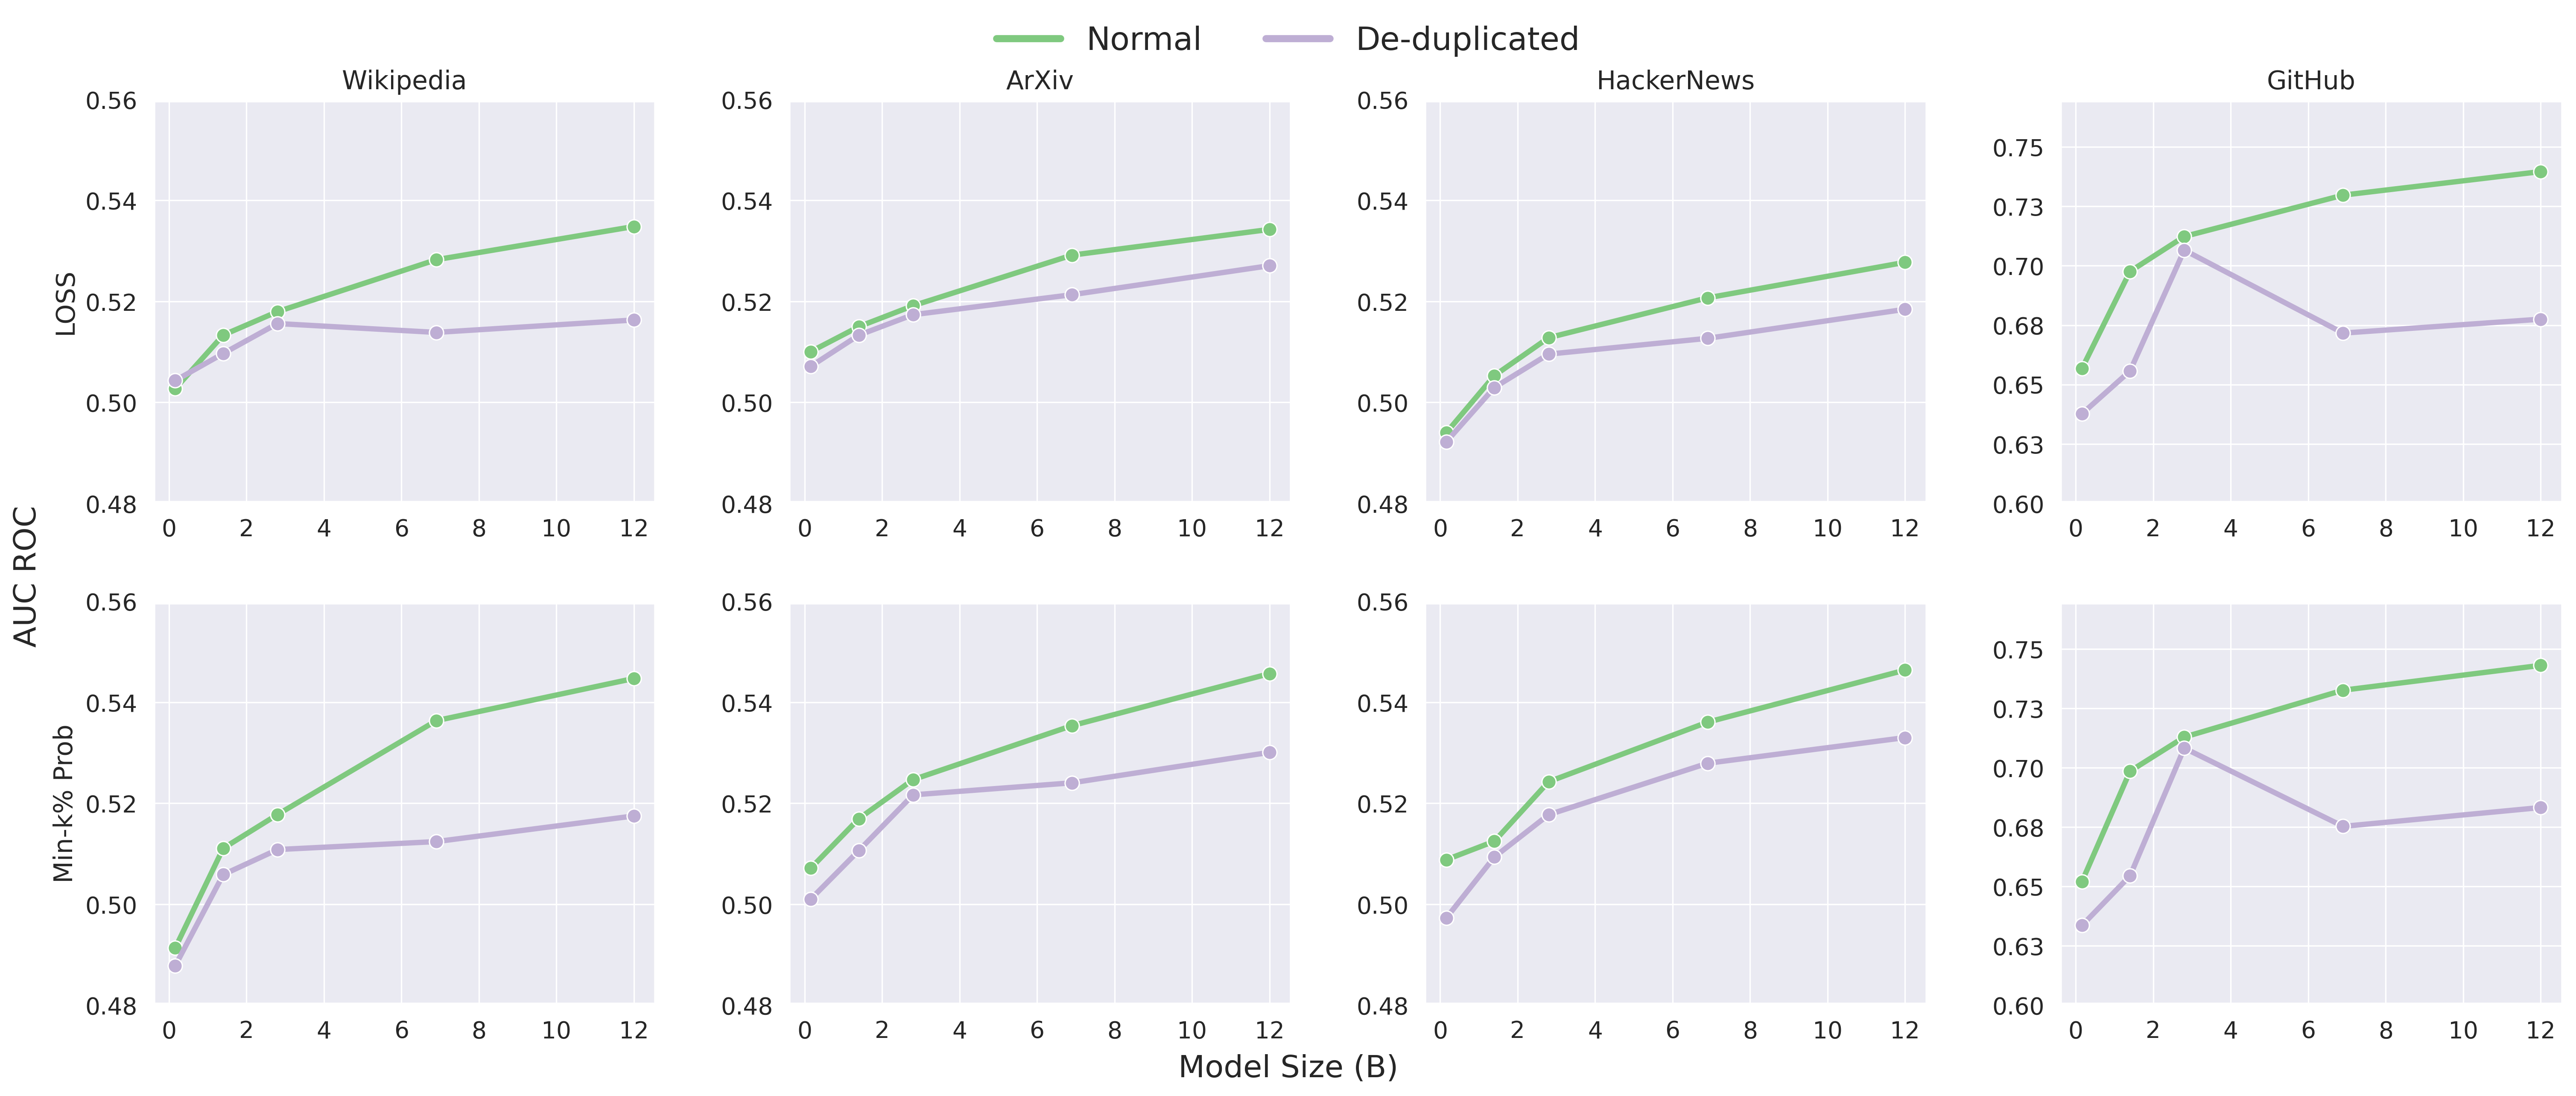

In [6]:
from collections import defaultdict
# Pythia deduped data size exp
# MODEL_SIZE_COLOR_MAPPING = {
#     '160m': '#66a61e',
#     '1.4b': '#1b9e77',
#     '2.8b': '#d95f02',
#     '6.9b': '#7570b3',
#     '12b': '#e7298a'
# }

OLD_TO_NEW = {
    'ref_model_gpt2_lira_ratio_threshold': 'ref-gpt2',
    'likelihood_threshold': 'loss',
    'zlib_entropy_threshold': 'zlib',
    'min_prob_k': 'min_k'
}

DOMAIN_SUFFIX = "_ngram_13_<0.8_truncated"
DOMAIN_SUFFIX_LEN = len(DOMAIN_SUFFIX)

# Collect results for graphing
results_file = './mia_unified_mia_v5_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format domain -> duped or deduped -> attack -> model_size -> auc 
organized_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for domain, results_per_model_size in results.items():
    domain = domain[:-DOMAIN_SUFFIX_LEN]
    for msr in results_per_model_size:
        model = msr['target']
        model_size = model.split('-')[1]
        dupe_state = "deduped" if "deduped" in model else "duped"
        for attack, performance in msr.items():
            if attack != 'target':
                old_attack_name = attack.split('_results.json')[0]
                attack_name = OLD_TO_NEW[old_attack_name]
                roc_auc = performance['roc_auc']
                organized_results[domain][dupe_state][attack_name][model_size] = roc_auc
                
print(organized_results.keys())
print(organized_results['arxiv'].keys())
print(organized_results['arxiv']['deduped'].keys())
print(organized_results['arxiv']['deduped']['loss'].keys())

DOMAINS_OF_INTEREST = {
    'wikipedia_(en)': "Wikipedia",
    'arxiv': "ArXiv",
#     'pubmed_central': 'PubMed Central',
    'hackernews': 'HackerNews',
    'github': "GitHub"
}

# May want to use full pile or pubmed central since that's where mink succeeds
DOMAINS_TO_ATTACKS = {
    'wikipedia_(en)': 'min_k', #'zlib',
    'arxiv': 'min_k',#'ref-gpt2',
#     'pubmed_central': 'min_k',
    'hackernews': 'min_k',
    'github': 'min_k',#'zlib'
}

DOMAINS_TO_YLIM = {
    'wikipedia_(en)': (.48, .56),
    'arxiv': (.48, .56),
#     'pubmed_central': (.48, .56),
    'hackernews': (.48, .56),
    'github': (.6, .77),
}
                
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 8, 'lines.linewidth': 3, 'axes.linewidth': 3})

# Create a figure and axis
fig, axs = plt.subplots(2, 4, figsize=(20,8),gridspec_kw={'wspace':0.1,'hspace':0.1},layout='constrained')

# Plot the data with Seaborn
for i, domain in enumerate(DOMAINS_OF_INTEREST.keys()):
    best_attack = DOMAINS_TO_ATTACKS[domain]
    model_sizes_sorted = sorted(MODEL_SIZES.items(), key=lambda x: x[1])
    model_names = [ms[0] for ms in model_sizes_sorted]
    model_sizes = [ms[1] for ms in model_sizes_sorted]
    print(model_sizes)
    y_loc = i
    
    for dupe_state, performance_per_attack in organized_results[domain].items():
        # Plot line for loss
        loss_performance = [performance_per_attack['loss'][ms] for ms in model_names]
        sns.lineplot(ax=axs[0, y_loc], x=model_sizes, y=loss_performance, color=COLOR_MAPPING['De-duplicated' if dupe_state == 'deduped' else 'Normal'], marker='o')
        
        # Plot line for best attack by domain
        ba_performance = [performance_per_attack[best_attack][ms] for ms in model_names]
        sns.lineplot(ax=axs[1, y_loc], x=model_sizes, y=ba_performance, color=COLOR_MAPPING['De-duplicated' if dupe_state == 'deduped' else 'Normal'], marker='o')

    axs[0, y_loc].set_title(DOMAINS_OF_INTEREST[domain])
#     axs[0, y_loc].xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     axs[1, y_loc].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    axs[0, y_loc].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[1, y_loc].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0, y_loc].xaxis.set_ticks(np.arange(0, 14, 2))
    axs[1, y_loc].xaxis.set_ticks(np.arange(0, 14, 2))
    axs[0, y_loc].set_ylim(DOMAINS_TO_YLIM[domain]) 
    axs[1, y_loc].set_ylim(DOMAINS_TO_YLIM[domain])
    if y_loc == 0:
        axs[0, y_loc].set_ylabel(ATTACK_MAP['loss'])
        axs[1, y_loc].set_ylabel(ATTACK_MAP[best_attack])

x_ax = fig.supxlabel('Model Size (B)')
y_ax = fig.supylabel('AUC ROC')


# # lines, labels = axs[0, 2].get_legend_handles_labels() 

# print(labels)
# lgd = fig.legend(lines, labels, loc='upper right') 
legend_lines, legend_names = [], []
for k, v in COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.05),
              borderaxespad=0, ncol=2, fontsize=18,
              facecolor='white', frameon=False)

# Save the figure
fig.savefig(f'model_size.png', bbox_inches='tight')

## Deduplication (needs ngram overlap of full_pile test set)

In [ ]:
import argparse
import json 
import os
import datasets
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

ngrams = ["ngram_7", "ngram_13"]
base_dir = "/gscratch/h2lab/micdun/bff/deduped/full_pile/"

subset_overlaps = defaultdict(lambda: defaultdict(dict))
for ngram in ngrams:
    shard_0 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram, "0", "test.jsonl.gz"), split="train", num_proc=8)#.filter(lambda x: x["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower() == subset, num_proc=8)
    print(shard_0)
    shard_1 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram, "1", "test.jsonl.gz"), split="train", num_proc=8)#.filter(lambda x: x["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower() == subset, num_proc=8)

    assert shard_0["original"][0] == shard_1["original"][0] and shard_0["original"][1] == shard_1["original"][1]
    for in0, in1 in tqdm(zip(shard_0, shard_1)):
        ngram_inclusion = np.array(in0["ngram_inclusion"][:200]) | np.array(in1["ngram_inclusion"][:200])
    
        subset = in0["meta"]["pile_set_name"].replace(" ", "_").replace("-", "_").lower()
        text = in0["original"]
        individual_ngram_overlap = np.mean(ngram_inclusion[:200])
        subset_overlaps[ngram][subset][text] = individual_ngram_overlap

In [ ]:
subsets = ["wikipedia_(en)", "github",  "arxiv", "hackernews"]#, "dm_mathematics"]#"pile_cc", "arxiv"]"gutenberg_(pg_19)" "pubmed_central",
ngrams = ["ngram_7"]#, "ngram_13"]
# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})
subset_color_map = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3', '#66a61e']
subset_name_map = ['Wikipedia', 'Github', 'ArXiv', "HackerNews", "DM Mathematics"]# 'Pile CC',  'ArXiv', 'Pubmed Central']

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams), len(subsets), figsize=(16,4 * len(ngrams)),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, ngram in enumerate(ngrams):
    for j, subset in enumerate(subsets):
        x_loc, y_loc = i, j
        curr_axs = axs[j] if len(ngrams) == 1 else axs[x_loc, y_loc]

        # Plot the histogram
        ino = subset_overlaps[ngram][subset]
        hplt = sns.histplot(ax=curr_axs, data=100 * np.array(list(ino.values())), bins=40, facecolor=subset_color_map[j], stat='probability')
#         if x_loc == 0 and y_loc == 0:    
#             curr_axs.set_ylabel("7-gram")
#         elif x_loc == 1 and y_loc == 0:    
#             curr_axs.set_ylabel("13-gram")
#         else:
        curr_axs.set_ylabel(None)

        if x_loc == 0:
            curr_axs.set_title(subset_name_map[j])
        #axs[x_loc, y_loc]
        curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
        if subset == 'github':
            curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            curr_axs.yaxis.set_ticks(np.arange(0, .45, .1))
        else:
            curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         hplt.legend_.remove()
        # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))

x_ax = fig.supxlabel('% 7-gram Overlap', y=-.1) #'% Overlap'
y_ax = fig.supylabel('Proportion of Data', x=-.02)

# Save the histograms
#plt.savefig("ngram_overlap_hist.png", bbox_inches='tight')

In [ ]:
subsets = ["github"]
ngrams = ["ngram_7"]#, "ngram_13"]
# Set Seaborn style
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})
subset_color_map = ['#fc8d62']
subset_name_map = ['GitHub']

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams), len(subsets), figsize=(4,4 * len(ngrams)),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

thirteen_gram_overlap = [(text, overlap) for text, overlap in subset_overlaps['ngram_13']['github'].items() if overlap < 0.8]
seven_gram_overlap = [subset_overlaps['ngram_7']['github'][text] for text, _ in thirteen_gram_overlap]
print(len(thirteen_gram_overlap))
print(len(seven_gram_overlap))
# for i, ngram in enumerate(ngrams):
#     for j, subset in enumerate(subsets):
#         x_loc, y_loc = i, j
#         curr_axs = axs[j] if len(ngrams) == 1 else axs[x_loc, y_loc]

#         # Plot the histogram
#         ino = subset_overlaps[ngram][subset]
hplt = sns.histplot(ax=axs, data=100 * np.array(seven_gram_overlap), bins=40, facecolor=subset_color_map[0], stat='probability')
# #         if x_loc == 0 and y_loc == 0:    
# #             curr_axs.set_ylabel("7-gram")
# #         elif x_loc == 1 and y_loc == 0:    
# #             curr_axs.set_ylabel("13-gram")
# #         else:
axs.set_xlabel('% 7-gram Overlap') #'% Overlap'
axs.set_ylabel('Proportion of Data')

#         if x_loc == 0:
#             curr_axs.set_title(subset_name_map[j])
#         #axs[x_loc, y_loc]
axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
#         if subset == 'github':
#             curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#         else:
#             curr_axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# #         hplt.legend_.remove()
#         # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))

# Save the histograms
plt.savefig("change_ngram_overlap_hist_github.png", bbox_inches='tight')

## ngram overlap vs score (needs results folder with MIA scores)

In [ ]:
import argparse
import json 
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
from tqdm import tqdm

# NGRAM_METADATA = "ngram_metadata.json"
ATTACKS = [
    "likelihood_threshold_results.json",
    "ref_model_gpt2_lira_ratio_threshold_results.json",
    "min_prob_k_results.json",
#     "zlib_entropy_threshold_results.json"
]

# ATTACKS = [
#     "loss_results.json",
#     "ref-gpt2_results.json",
#     "min_k_results.json",
#     "zlib_results.json"
# ]

ATTACK_NAMES = [
    "LOSS",
    "Reference-based",
    "Min-k% Prob",
    "Zlib"
]
    
sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})

charts = [
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/wikipedia_(en)", "subset_raw": "wikipedia_(en)", "subset": "Wikipedia", "ngram": "7-gram", "compute_overlap": True},
    {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/github", "subset_raw": "github", "subset": "GitHub", "ngram": "7-gram", "compute_overlap": True},
    {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/arxiv", "subset_raw": "arxiv", "subset": "ArXiv", "ngram": "7-gram", "compute_overlap": True},
     {"path": "/gscratch/h2lab/micdun/bff/deduped/existing_nonmembers/ngram_7/hackernews", "subset_raw": "hackernews", "subset": "HackerNews", "ngram": "7-gram", "compute_overlap": True},
]

# charts = [
#     {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/wikipedia_(en)/test_text.jsonl", "subset_raw": "wikipedia_(en)", "subset": "Wikipedia", "ngram": "13-gram", "compute_overlap": False},
#     {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/github/test_text.jsonl", "subset_raw": "github", "subset": "GitHub", "ngram": "13-gram", "compute_overlap": False},
#         {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/arxiv/test_text.jsonl", "subset_raw": "arxiv", "subset": "ArXiv", "ngram": "13-gram", "compute_overlap": False},
#         {"path": "/gscratch/h2lab/micdun/mimir/data/ngram_overlap_thresholded_pile_subsets/truncated+ngram_13/0.0-0.8/hackernews/test_text.jsonl", "subset_raw": "hackernews", "subset": "HackerNews", "ngram": "13-gram", "compute_overlap": False},
# ]
# charts = [
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/temporal_arxiv/ngram_7/arxiv_2023-06", "subset_raw": "temporal_arxiv", "subset": "Temporal ArXiv - 2023/06", "ngram": "7-gram", "compute_overlap": True},
#     {"path": "/gscratch/h2lab/micdun/bff/deduped/temporal_arxiv/ngram_7/arxiv_2023-06", "subset_raw": "temporal_arxiv", "subset": "Temporal ArXiv - 2023/06", "ngram": "7-gram", "compute_overlap": True},
# ]

# Create a figure and axis
fig, axs = plt.subplots(len(ATTACKS), len(charts), figsize=(len(ATTACKS) * 7,len(charts) * 4),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')
color_map = {
    "Wikipedia": "#c2a5cf",
    "GitHub": "#a6dba0",
    "ArXiv": "#386cb0",
    "HackerNews": "#fdc086",
    "WikiMIA": "#c2a5cf",
    "Temporal ArXiv - 2023/06": "#fdc086"
}

threshold = 1

def get_ngram_overlap(shard_0_file, shard_1_file):
    shard_0 = datasets.load_dataset("json", data_files=shard_0_file, split="train")
    print(shard_0)
    shard_1 = datasets.load_dataset("json", data_files=shard_1_file, split="train")
    ngram_inclusion = [np.array(in0) | np.array(in1) for in0, in1 in zip(shard_0["ngram_inclusion"], shard_1["ngram_inclusion"])]
    return [(i, np.mean(d[:200])) for i, d in enumerate(ngram_inclusion) if np.mean(d[:200]) <= threshold]

for i, chart in enumerate(charts):
    if chart["compute_overlap"]:
        print("computing overlap for", chart)
        shard_0_f = os.path.join(chart["path"], "0", "test_raw.jsonl.gz") #test_raw.jsonl.gz  "WikiMIA128_nonmembers.jsonl.gz"
        shard_1_f = os.path.join(chart["path"], "1", "test_raw.jsonl.gz")
        ngram_overlap = get_ngram_overlap(shard_0_f, shard_1_f)
    else:
        print("existing overlap for", chart)
        ngram_metadata_file = chart["path"]
        ngram_metadata_ds = datasets.load_dataset("json", data_files=ngram_metadata_file, split="train")
        ngram_overlap = [(i, o) for i, o in enumerate(ngram_metadata_ds["overlap"]) if o <= threshold]
    
    indices = [i for i, o in ngram_overlap]
    ngram_overlap = [o for i, o in ngram_overlap]
    

    nonmember_overlap = np.array(ngram_overlap) * 100
    
    for j, attack in enumerate(ATTACKS):
        ax = axs[j, i]
#         results_dir = "/mmfs1/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5_temporal_arxiv/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-arxiv_2023_06/"
        results_dir = f"/gscratch/h2lab/micdun/mimir/results_new/mia_unified_mia_v5/EleutherAI_pythia-12b-deduped--bert-temp/fp32-0.3-1-the_pile-the_pile-1000200100_plen30_--tok_false-{chart['subset_raw']}_ngram_13_<0.8_truncated/"
        # Load results dictionaries
        f_attack = open(f'{results_dir}/{attack}')
        attack_dict = json.load(f_attack)

        nonmember_scores = np.array(attack_dict["predictions"]["nonmembers"])[indices] # old: nonmembers, new: nonmember
#         member_scores = np.array(attack_dict["predictions"]["members"])

        # pearson r
        r, p = stats.pearsonr(nonmember_overlap, nonmember_scores)

        # Fit a 1st degree polynomial (a line) to the data
        m, c = np.polyfit(nonmember_overlap, nonmember_scores, 1)

        # Generate y-values for the line of best fit
        x_fit = np.arange(0,101,1)
        y_fit = m * x_fit + c

        # Scatter plot
        ax.scatter(nonmember_overlap, nonmember_scores, alpha=0.5, c=color_map[chart["subset"]], cmap='hot',label = 'nonmember')
#         ax.scatter([100] * len(member_scores), member_scores, alpha=0.25, c='red', cmap='hot',label = 'member')
        # Plot the line of best fit
        ax.plot(x_fit, y_fit, c='black', linestyle="--", linewidth="1" )
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
#         ax.set_xlabel(f"% {chart['ngram']} overlap")
        if j == 0:
            ax.set_title(f"{chart['subset']}", fontsize=24)
        if i == 0:
            ax.set_ylabel(ATTACK_NAMES[j], fontsize=20)
        ax.annotate('$r$ = {:.3f}'.format(r), xy=(0.80, 0.85), xycoords='axes fraction')
fig.supxlabel(f"% 7-gram overlap", fontsize=24)

Epoch Count

In [ ]:
# Datablations - C4 & SILO PDSW semibalanced - HackerNews

fig, axs = plt.subplots(1, 3, figsize=(18,5),gridspec_kw={'wspace':0.1,'hspace':0.1},layout='constrained')
db_epoch_counts = [1,2,4,6,14]
db_loss_score = [0.5245619, 0.5322267, 0.551066, 0.570878, 0.660227]
db_ref_score = [0.520745, 0.535620, 0.571349, 0.60882185, 0.751708]
db_mink_score = [0.530927, 0.537447, 0.560082, 0.587850, 0.6883875]
db_zlib_score = [0.518979, 0.525365, 0.540966, 0.5557319, 0.627332]

silo_epoch_counts = [2.1, 4.8, 6, 9.4]
silo_loss_score = [0.5639506, 0.59378, 0.62567, 0.638829]
silo_ref_score = [0.579588, 0.61240, 0.647429, 0.65589]
silo_mink_score = [0.597689, 0.63777, 0.67048, 0.668295]
silo_zlib_score = [0.54046, 0.56109, 0.58246, 0.59916]

silo_dm_epoch_counts = [2.1, 4.8, 6, 9.4]
silo_dm_loss_score = [0.5050442787281165, 0.4951302092438392, 0.494672898809211, 0.4925665260299304]
silo_dm_ref_score = [0.49677251598337135, 0.49344313220213065, 0.49244507097317164, 0.4941454744808909]
silo_dm_mink_score = [0.5113125960690379, 0.49987695772801954, 0.4977620919543997, 0.4962532541804649]
silo_dm_zlib_score = [0.49532420978364083, 0.4903203995723673, 0.4880661804185572, 0.4865161019433974]

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 8, 'lines.linewidth': 3, 'axes.linewidth': 3})

db_ax = axs[0]
silo_ax = axs[1]
silo_dm_ax = axs[2]


# Plot the data with Seaborn fro datablations
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-gpt2'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])
sns.lineplot(ax=db_ax, x=db_epoch_counts, y=db_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
db_ax.set_title('Datablations - C4')

# Plot the data with Seaborn
sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-gpt2'])#, label='LOSS')
sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])#, label='Reference-based')
sns.lineplot(ax=silo_ax, x=silo_epoch_counts, y=silo_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
silo_ax.set_title('SILO-PDSW - HackerNews')

sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_mink_score, marker='o', color=ATTACK_COLOR_MAPPING['ref-gpt2'])#, label='LOSS')
sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_ref_score, marker='o', color=ATTACK_COLOR_MAPPING['min_k'])#, label='Reference-based')
sns.lineplot(ax=silo_dm_ax, x=silo_epoch_counts, y=silo_dm_zlib_score, marker='o', color=ATTACK_COLOR_MAPPING['zlib'])
silo_dm_ax.set_title('SILO-PDSW - DM Mathematics')

legend_lines, legend_names = [], []
for k, v in ATTACK_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(ATTACK_MAP[k])
    
# db_ax.set_xlim((0, 15))
# silo_ax.set_xlim((0, 15))

fig.supxlabel('Number of Training Epochs')
fig.supylabel('AUC ROC')

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0, ncol=4, fontsize=18,
              facecolor='white', frameon=False)

# Save the figure
fig.savefig(f'num_epoch_count.png', bbox_inches='tight')

## Training Data Size

In [ ]:
from collections import defaultdict
# Pythia deduped data size exp

datasizes = [
    1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000,
    55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 99000]

# Collect results for graphing
results_file = './mia_unified_mia_v5_linear_tds_recency_hyp_results.json'# '/gscratch/h2lab/micdun/mimir/local/mia_unified_mia_v5_linear_tds_hyp_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format attack -> model_size -> ckpt -> auc 
organized_results = defaultdict(lambda: defaultdict(dict))
for ckpt, results_per_model_size in results.items():
    ckpt_num = int(ckpt.split('_')[1])
    for msr in results_per_model_size:
        model = msr['target']
        model_size = model.split('-')[1]
        for attack, performance in msr.items():
            if attack != 'target':
                attack_name = attack.split('_results.json')[0]
                roc_auc = performance['roc_auc']
                organized_results[attack_name][model_size][ckpt_num] = roc_auc
                
# print(organized_results['ref-gpt2'])
# print(len(organized_results['ref-gpt2']['1.4b']))

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 8, 'lines.linewidth': 3, 'axes.linewidth': 3})

# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=(16,8),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, (attack, results) in enumerate(organized_results.items()):
    x_loc, y_loc = i // 2, i % 2
    
    for model_size, performance_per_ckpt in results.items():
        performance = [performance_per_ckpt[d] for d in datasizes]
        sns.lineplot(ax=axs[x_loc, y_loc], x=datasizes, y=performance, color=MODEL_SIZE_COLOR_MAPPING[model_size], marker='o')

    axs[x_loc, y_loc].set_title(ATTACK_MAP[attack])
    axs[x_loc, y_loc].set_ylim((0.5, 0.63)) #(0.48, 0.77)
    axs[x_loc, y_loc].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
fig.supxlabel('Number of Training Steps')
fig.supylabel('AUC ROC')

legend_lines, legend_names = [], []
for k, v in MODEL_SIZE_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(k)

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.05),
              borderaxespad=0, ncol=4, fontsize=18,
              facecolor='white', frameon=False)

# # Legend plot
# plt.figlegend(legend_lines, legend_names,
#               loc='upper center', bbox_to_anchor=(0.5, 1.05),
#               borderaxespad=0, ncol=2, fontsize=12)

# Save the figure
fig.savefig(f'data_recency.png', bbox_inches='tight')

## Special MIA: Temporal ArXiv

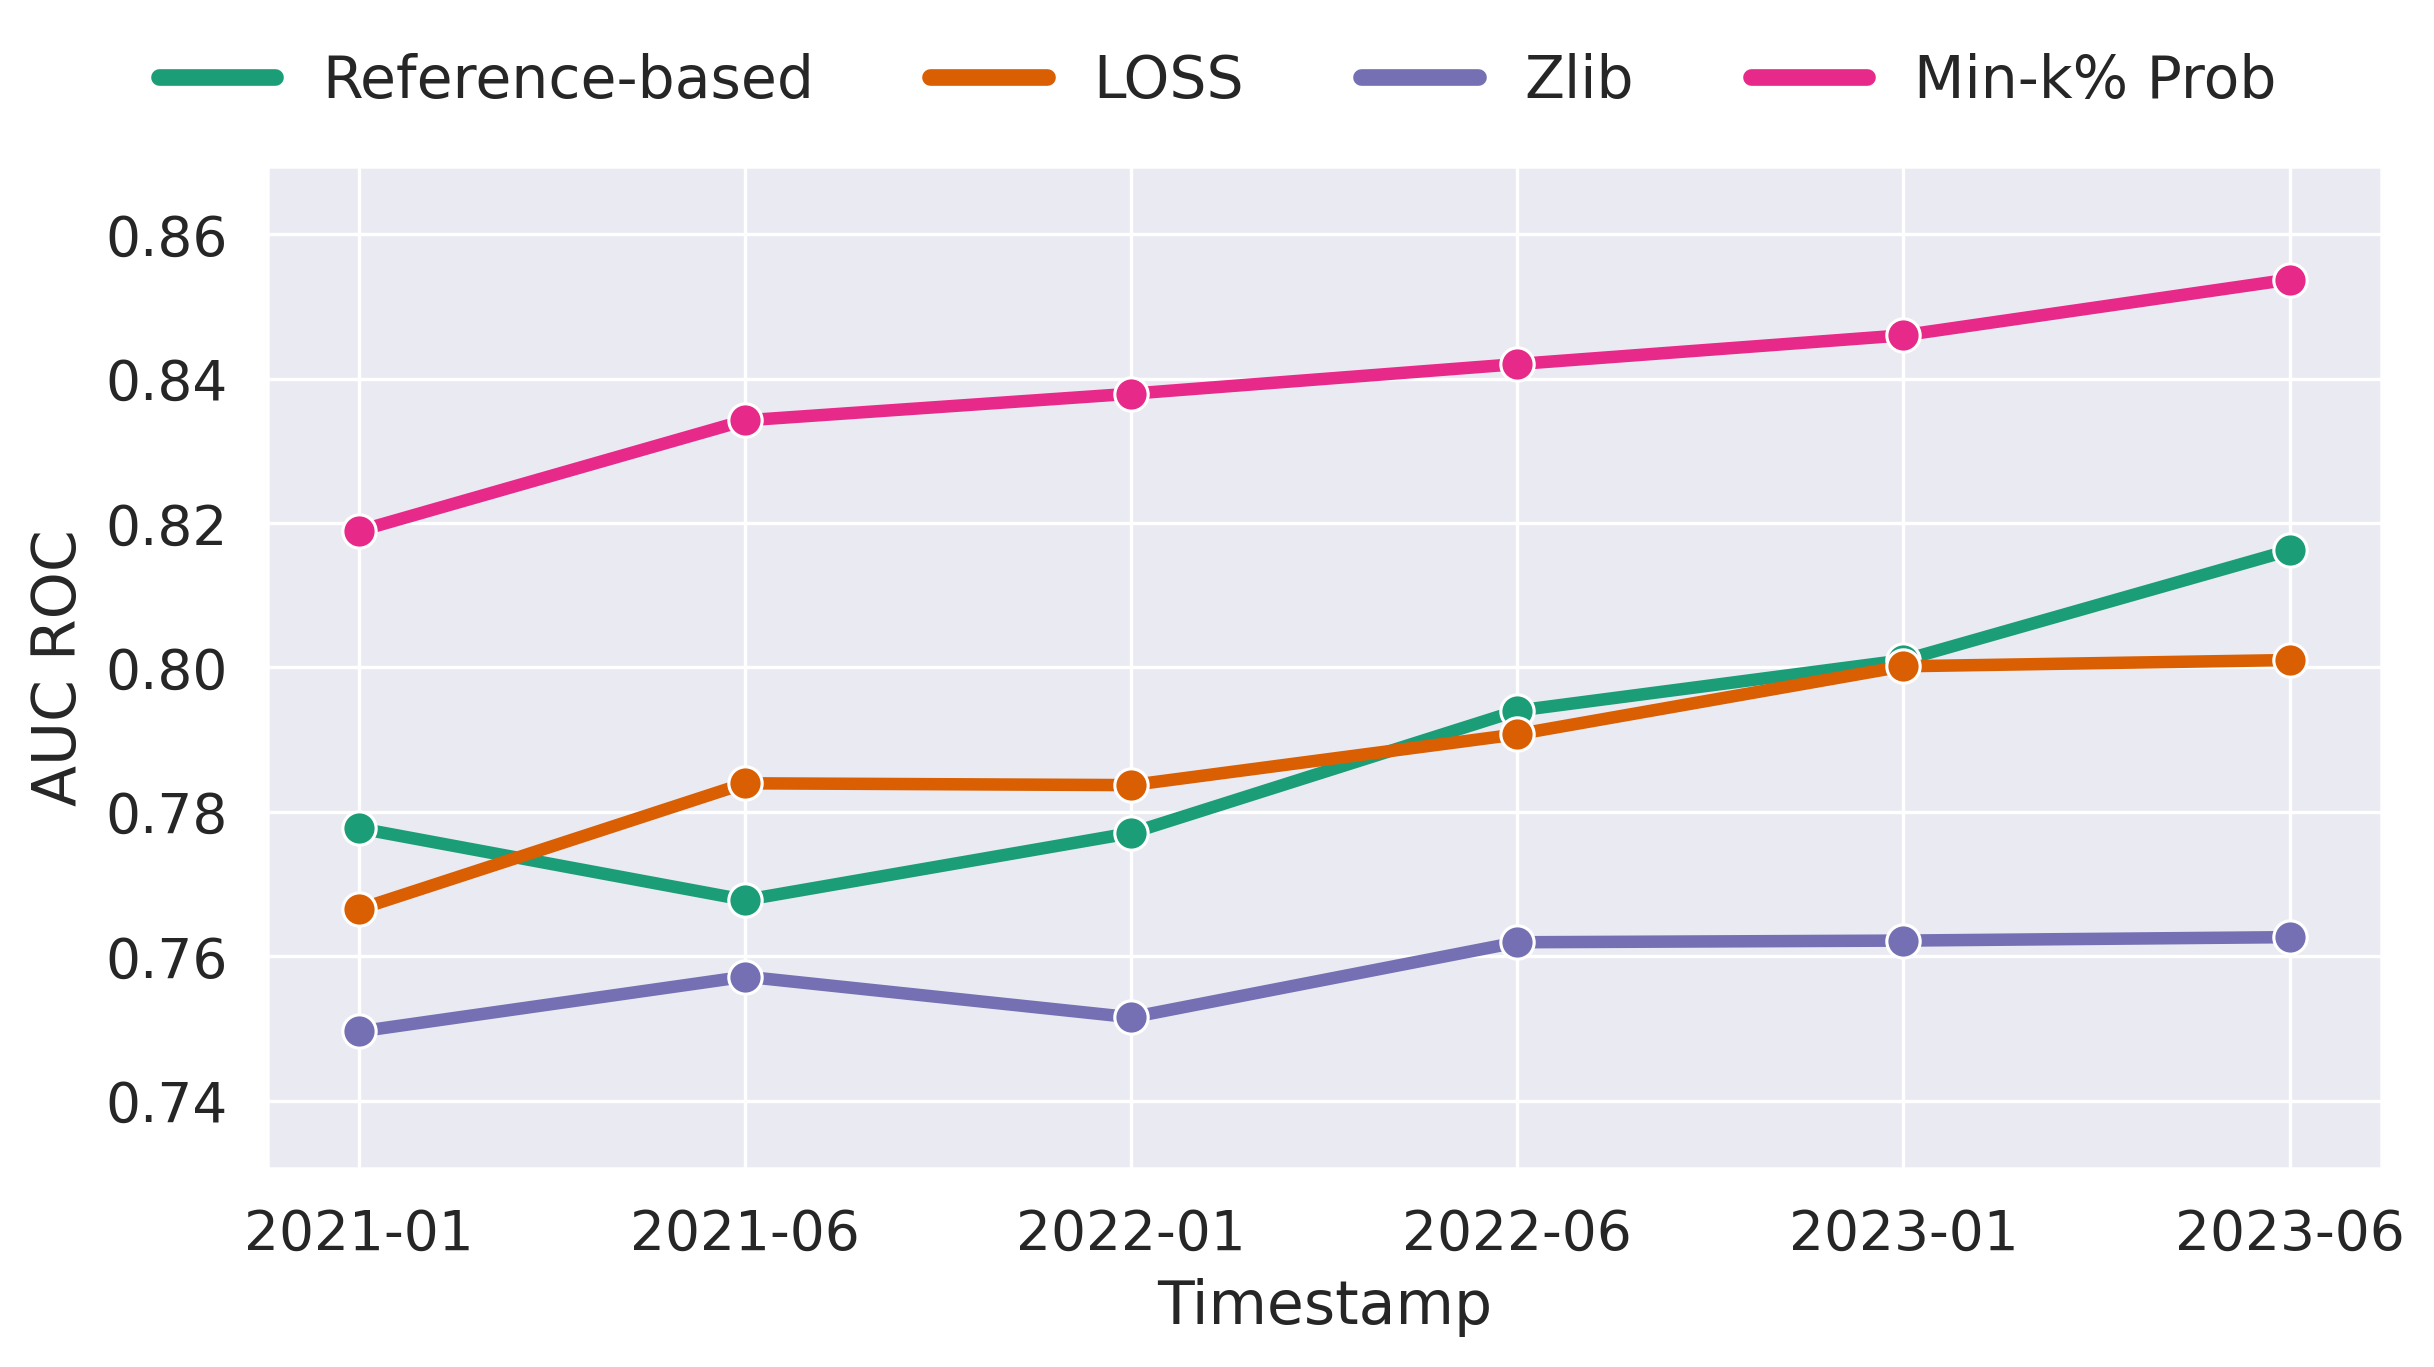

In [7]:
from collections import defaultdict
# Pythia deduped data size exp

dates = ['2021-01', '2021-06', '2022-01', '2022-06', '2023-01', '2023-06']

# Collect results for graphing
results_file = './mia_unified_mia_v5_temporal_arxiv_results.json'
with open(results_file, 'r') as f:
    results = json.load(f)
    
# Reorganize results into a dictionary in the format attack -> timestamp -> auc 
organized_results = defaultdict(dict)
for ts, results in results.items():
    ts = '-'.join(ts.split('_')[1:])
    r = results[0]
    for attack, performance in r.items():
        if attack != 'target':
            attack_name = attack.split('_results.json')[0]
            roc_auc = performance['roc_auc']
            organized_results[attack_name][ts] = roc_auc

# print(organized_results)

sns.set(style="darkgrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 8, 'lines.linewidth': 3, 'axes.linewidth': 3})

# Create a figure and axis
fig, axs = plt.subplots(1, 1, figsize=(8,4),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, (attack, results) in enumerate(organized_results.items()):
    performance = [results[d] for d in dates]
    sns.lineplot(ax=axs, x=dates, y=performance, color=ATTACK_COLOR_MAPPING[attack], marker='o')

    axs.set_ylim((0.73, 0.87))
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
axs.set_xlabel('Timestamp')
axs.set_ylabel('AUC ROC')

legend_lines, legend_names = [], []
for k, v in ATTACK_COLOR_MAPPING.items():
    legend_lines.append(Line2D([0], [0], color=v, lw=4))
    legend_names.append(ATTACK_MAP[k])

# Legend plot
plt.figlegend(legend_lines, legend_names,
              loc='upper center', bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0, ncol=4, fontsize=14,
              facecolor='white', frameon=False)

# # Legend plot
# plt.figlegend(legend_lines, legend_names,
#               loc='upper center', bbox_to_anchor=(0.5, 1.05),
#               borderaxespad=0, ncol=2, fontsize=12)

# Save the figure
fig.savefig(f'temporal_arxiv.png', bbox_inches='tight')


In [ ]:
# Overlap graphs for temporal arxiv
import json 
import os
import datasets
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

ngrams = ["7-gram"]#, "13-gram"]
ngram_file_map = {
    "7-gram": "ngram_7",
    "13-gram": "ngram_13"
}
ngram_ylim_map = {
    "7-gram": (0, 0.14),
    "13-gram": (0, 0.9)
}
base_dir = "/gscratch/h2lab/micdun/bff/deduped/wikiMIA/"
timestamps = ['WikiMIA'] #['2021-01','2023-06']

subset_overlaps_temporal = defaultdict(lambda: defaultdict(dict))
for ngram in ngrams:
    for ts in timestamps:
        shard_0 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram_file_map[ngram], "0", "WikiMIA128_nonmembers.jsonl.gz"), split="train") #f'arxiv_{ts}', "test_raw.jsonl.gz"
        print(shard_0)
        shard_1 = datasets.load_dataset("json", data_files=os.path.join(base_dir, ngram_file_map[ngram], "1", "WikiMIA128_nonmembers.jsonl.gz"), split="train")

        assert shard_0["original"][0] == shard_1["original"][0] and shard_0["original"][1] == shard_1["original"][1]
        ngram_inclusion = [np.array(in0) | np.array(in1) for in0, in1 in zip(shard_0["ngram_inclusion"], shard_1["ngram_inclusion"])]
        individual_ngram_overlap = {text: np.mean(d[:200]) for text, d in zip(shard_0["original"], ngram_inclusion)}
        subset_overlaps_temporal[ts][ngram] = individual_ngram_overlap

# Set Seaborn style
sns.set(style="whitegrid")
sns.set_context("paper", font_scale = 1.5, rc={'lines.markersize': 5, 'lines.linewidth': 3, 'axes.linewidth': 3})
subset_color_map = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
subset_name_map = ['Wikipedia', 'Github', 'Pubmed Central', 'Pile CC']

# Create a figure and axis
fig, axs = plt.subplots(len(ngrams), len(timestamps) + 1, figsize=(len(timestamps)*4 + 4, len(ngrams)*4),gridspec_kw={'wspace':0.05,'hspace':0.05},layout='constrained')

for i, ngram in enumerate(ngrams):
    for j, ts in enumerate(timestamps):
        curr_axs = axs[j+1] if len(ngrams) == 1 else axs[i, j+1]

        # Plot the histogram
        ino = subset_overlaps_temporal[ts][ngram]
        print(f"{ts}:", np.mean(list(ino.values())))
        hplt = sns.histplot(ax=curr_axs, data=100 * np.array(list(ino.values())), bins=40, facecolor=subset_color_map[j+1], stat='probability')

        curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
    #         hplt.legend_.remove()
        curr_axs.set_ylim(ngram_ylim_map[ngram])
        curr_axs.set_ylabel(None)
        if i == 0:
            curr_axs.set_title(f"{ts}")
        # plt.hist(individual_ngram_overlap_values, bins=100, range=(0, 1))
        
    # Add original distribution plot
    original_distribution = [overlap for _, overlap in subset_overlaps[ngram_file_map[ngram]]['wikipedia_(en)'].items()] # arxiv
    print("original:", np.mean(original_distribution))
    curr_axs = axs[0] if len(ngrams) == 1 else axs[i, 0]
    
    hplt = sns.histplot(ax=curr_axs, data=100 * np.array(original_distribution), bins=40, facecolor=subset_color_map[0], stat='probability')
    curr_axs.set_xticks(np.array([0, 0.2, 0.4, 0.6, .8, 1]) * 100)
    #         hplt.legend_.remove()
    curr_axs.set_ylim(ngram_ylim_map[ngram])
    curr_axs.set_ylabel('Proportion of Data')
    if i == 0:
        curr_axs.set_title(f"Original")

x_ax = fig.supxlabel('% 7-gram Overlap')
# y_ax = fig.supylabel('Proportion of Data')

# Save the histograms
#plt.savefig(f"temporal_arxiv_{ts}_ngram_overlap_hist.png", bbox_inches='tight')
plt.savefig(f"wikimia_ngram_overlap_hist.png", bbox_inches='tight')